In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from create_labels import *
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random

from dataset_generator import DatasetGenerator
from models.unet_tensorflow import model


2022-05-28 01:47:42.194217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 01:47:42.285941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 01:47:42.286711: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-28 01:47:42.390483: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [2]:
AOI_PATH = '/home/melih/Code/uni/sem6/space_net/train/AOI_11_Rotterdam'
image_type = 'PS-RGB'


img_path_prototype = f'{AOI_PATH}/{image_type}/SN6_Train_AOI_11_Rotterdam_{image_type}_'
summary = load_summary(f'{AOI_PATH}/SummaryData/SN6_Train_AOI_11_Rotterdam_Buildings.csv')

    
img_ids = list(set(summary['ImageId']))
reidx = random.sample(population = list(range(len(img_ids))), k = len(img_ids))
img_ids = np.array(img_ids)[reidx]
    
img_ids = img_ids[:1000]

In [3]:
dg = DatasetGenerator(
    list(set(summary['ImageId'])), 
    summary, 
    img_path_prototype
)


In [29]:
import random
samples = random.choices(dg, k=12)
samples = list(zip(*samples))

samples_img = np.asarray(samples[0])
samples_label = np.asarray(samples[1])


12

In [4]:
dg = DatasetGenerator(img_ids, summary, img_path_prototype)
ot = (tf.float32, tf.int64)
os = (tf.TensorShape([256, 256, 3]), tf.TensorShape([256, 256, 1]))
dataset = tf.data.Dataset.from_generator(dg, ot, os).batch(8)

In [5]:
def show(image, label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax2.imshow(label)

In [6]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

tf.Tensor(1, shape=(), dtype=int64)


2022-05-25 15:08:34.273560: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8400


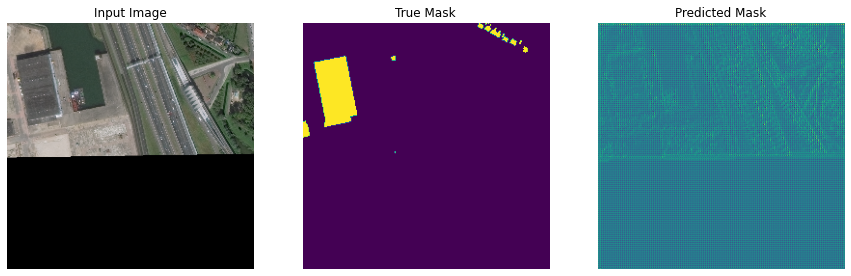

In [7]:
for image, label in dataset.take(1):
    #show(image, label)
    sample_image = image[0]
    sample_mask = label[0]
    print(tf.keras.backend.max(sample_mask))

def create_mask(pred_mask):
  #pred_mask = tf.math.argmax(pred_mask, axis=-1)
  #pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
  
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

show_predictions(dataset=dataset)

In [8]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [9]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
#STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
   tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5144)])
  except RuntimeError as e:
   print(e)


Virtual devices cannot be modified after being initialized


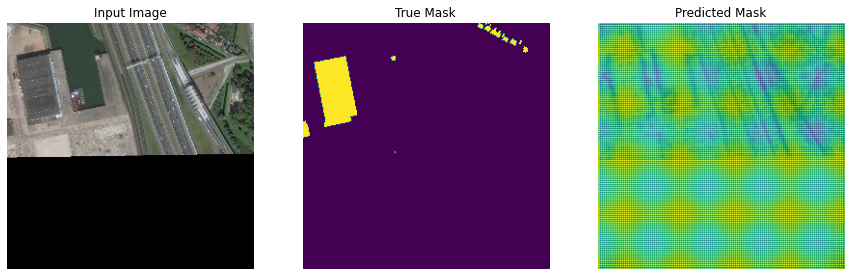


Sample Prediction after epoch 20

125/125 [==============================] - 42s 333ms/step - loss: 0.2252 - accuracy: 0.9350


In [11]:
EPOCHS = 20

model_history = model.fit(dataset, epochs=EPOCHS, callbacks=[DisplayCallback()])

In [12]:
n = 4
summary = load_summary()
list_ds = tf.data.Dataset.list_files('./datasets/train/AOI_11_Rotterdam/PS-RGB/*')

fig, axs = plt.subplots(n, 2, figsize=(9 * 2, 9*n))

for i, e in enumerate(list_ds.take(n)):
    id = e.numpy()[75:-4].decode("utf-8") 
    mask = mask_from_id(id, summary)
    axs[i, 0].imshow(mask)
    axs[i, 0].yaxis.set_ticks([])
    axs[i, 0].xaxis.set_ticks([])
    axs[i, 0].set_ylabel(id)
    axs[i, 0].set_xlabel('Mask')
    # overlay
    img = Image.open(e.numpy().decode("utf-8"))
    img1 = np.array(img)
    img1[mask == 2] = [0, 255, 0]
    axs[i, 1].imshow(img1)
    axs[i, 1].yaxis.set_ticks([])
    axs[i, 1].xaxis.set_ticks([])
    axs[i, 1].set_xlabel('Image with overlayed Borders')


FileNotFoundError: [Errno 2] No such file or directory: './datasets/train/AOI_11_Rotterdam/SummaryData/SN6_Train_AOI_11_Rotterdam_Buildings.csv'

## Unet Testing

In [ ]:
from models.test_net import build_model, finalize_model
unet = build_model(nx=256, ny=256, channels=3, num_classes=1, layer_depth=5)
finalize_model(unet)

In [ ]:
unet.fit(dataset, epochs=1)

2022-05-15 19:52:52.301964: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


    425/Unknown - 1286s 3s/step - loss: 0.0000e+00 - categorical_crossentropy: 0.0000e+00 - categorical_accuracy: 1.0000 - mean_iou: 0.0913 - dice_coefficient: 0.1550 - auc: 0.5000

2022-05-15 20:14:18.708586: W tensorflow/core/framework/op_kernel.cc:1733] INVALID_ARGUMENT: TypeError: list indices must be integers or slices, not list
Traceback (most recent call last):

  File "/Users/lld/miniforge3/envs/deep_cv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/Users/lld/miniforge3/envs/deep_cv/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/Users/lld/miniforge3/envs/deep_cv/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/lld/Documents/SoSe 2022/Projects in deep computer vision/deep_cv/dataset_generator.py", line 70, in __call__
    self.on_epoch_end()

  File "/Users/lld/Documents/SoSe 2022/Projects in deep computer vision/deep_cv/dataset_generator.py", line 76, in on_epoch_end
   

InvalidArgumentError:  TypeError: list indices must be integers or slices, not list
Traceback (most recent call last):

  File "/Users/lld/miniforge3/envs/deep_cv/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 275, in __call__
    ret = func(*args)

  File "/Users/lld/miniforge3/envs/deep_cv/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 649, in wrapper
    return func(*args, **kwargs)

  File "/Users/lld/miniforge3/envs/deep_cv/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py", line 992, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "/Users/lld/Documents/SoSe 2022/Projects in deep computer vision/deep_cv/dataset_generator.py", line 70, in __call__
    self.on_epoch_end()

  File "/Users/lld/Documents/SoSe 2022/Projects in deep computer vision/deep_cv/dataset_generator.py", line 76, in on_epoch_end
    self.tile_ids = self.tile_ids[reidx]

TypeError: list indices must be integers or slices, not list


	 [[{{node PyFunc}}]]
	 [[IteratorGetNext]] [Op:__inference_train_function_4503]

In [ ]:
for image, label in dataset.take(5):
    pred = unet(image)
    print(tf.shape(image), tf.shape(label), tf.shape(pred))
    show(image[0], pred[0])